In [2]:
!pip install codecarbon

  Using cached arrow-1.3.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached arrow-1.3.0-py3-none-any.whl (66 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.4 MB/s eta 0:00:00
Using cached rich-13.9.4-py3-none-any.whl (242 kB)
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached shellingham-1.5.4-py2.py3-none-any.whl (9.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 83.3 MB/s eta 0:00:00
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)


In [1]:
import os
import warnings
import datetime


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# for padding a list of variable length tensors to equal length
from torch.nn.utils.rnn import pad_sequence
# for packing a tensor containing padded sequences of variable length
from torch.nn.utils.rnn import pack_padded_sequence

import nltk
# for removing stop words like 'the', 'and', etc
# stop words don't provide useful information
from nltk.corpus import stopwords
# for tokenization
from nltk.tokenize import word_tokenize

# for counting the number of unique tokens
from collections import Counter
from codecarbon import EmissionsTracker

In [2]:
# suppress all warnings
warnings.filterwarnings("ignore")

# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
# Load the concatenated_MV file as a pandas DataFrame
file_path = 'concatenated_MV.xlsx'  # Update this path to the actual file location
df_loreal = pd.read_excel(file_path)


# Display the first few rows of the DataFrame
print(df_loreal.head())

                                         description  dark_pigmentation  acne  \
0  Australian Gold Deviously Black 45X Dark Bronz...                  0     0   
1  Australian Gold Sunscreen  Spray Gel with Inst...                  0     0   
2  Australian Gold Sunscreen Spray Gel - SPF 15 -...                  0     0   
3  Avalon Organics Intense Defense Oil-Free Moist...                  0     0   
4  Avalon Organics Vitamin C Renewal Facial Cream...                  0     0   

   eye_contour  homogeneity  lack_firmness  lack_radiance  pores  fine_lines  \
0            0            0              0              0      0           0   
1            0            0              0              1      0           0   
2            0            0              0              0      0           0   
3            0            0              0              0      0           0   
4            0            1              0              1      0           0   

   wrinkles_fine-lines  ...  fem

In [4]:
# Extract the output class names (column names excluding the text column)
output_classes = list(df_loreal.columns[1:34])  # Exclude the 'text_raw' column

num_classes = len(output_classes)

# Display the output
print(f"Number of output classes: {num_classes}")
print("List of output classes:")
print(output_classes)

Number of output classes: 33
List of output classes:
['dark_pigmentation', 'acne', 'eye_contour', 'homogeneity', 'lack_firmness', 'lack_radiance', 'pores', 'fine_lines', 'wrinkles_fine-lines', 'eye-wrinkles', 'undereye-bags', 'generic', '18-34', '35-54', '55-99', 'dry', 'normal', 'oily', 'combination', 'sensitivity-high', 'sensitivity-low', 'no_sensitivity', 'male', 'female', 'cleanse', 'prepare', 'treat', 'targeted', 'care', 'moisturize', 'protect', 'day', 'night']


In [5]:
# ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# set the stop words to the English mode
stop_words = set(stopwords.words('english'))

# define a function for pre-processing
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # remove stop words
    return tokens

# Apply preprocessing to the 'text_raw' column
df_loreal["tokens"] = df_loreal["description"].apply(preprocess_text)

# Display first few tokenized samples
df_loreal[["description", "tokens"]].head()

[nltk_data] Downloading package punkt to /Users/sebastian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sebastian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sebastian/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,description,tokens
0,Australian Gold Deviously Black 45X Dark Bronz...,"[australian, gold, deviously, black, 45x, dark..."
1,Australian Gold Sunscreen Spray Gel with Inst...,"[australian, gold, sunscreen, spray, gel, inst..."
2,Australian Gold Sunscreen Spray Gel - SPF 15 -...,"[australian, gold, sunscreen, spray, gel, -, s..."
3,Avalon Organics Intense Defense Oil-Free Moist...,"[avalon, organics, intense, defense, oil-free,..."
4,Avalon Organics Vitamin C Renewal Facial Cream...,"[avalon, organics, vitamin, c, renewal, facial..."


In [6]:
# build vocabulary
all_tokens = [token for tokens in df_loreal['tokens'] for token in tokens]
token_counts = Counter(all_tokens)
print('The number of unique tokens in the vocabulary:', len(token_counts))

The number of unique tokens in the vocabulary: 24064


Fitted Normal Distribution: mu = 25.94, sigma = 392.86


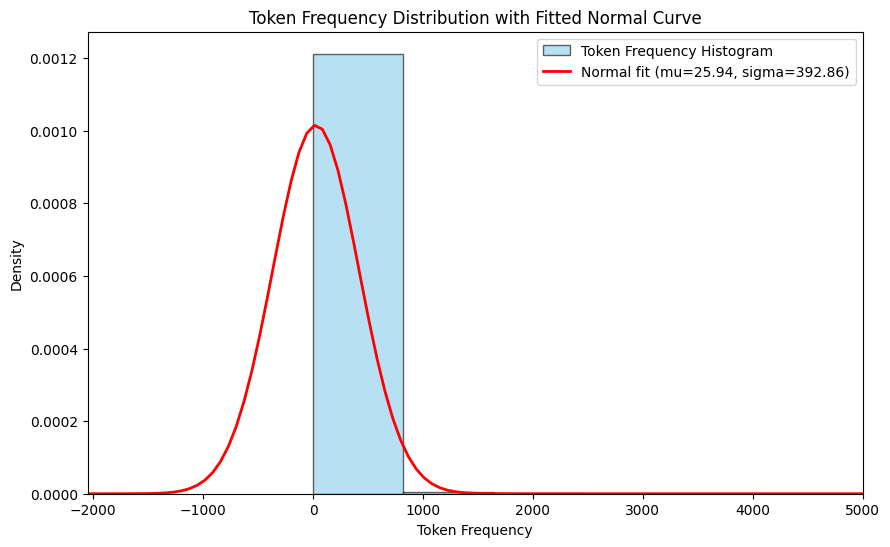

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assume token_counts is already defined from our vocabulary creation step:
# token_counts = Counter(all_tokens)

# Get an array of token frequencies
frequencies = np.array(list(token_counts.values()))

# Plot the histogram of token frequencies
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(frequencies, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Token Frequency Histogram')

# Fit a normal distribution to the frequency data
mu, sigma = norm.fit(frequencies)
print(f"Fitted Normal Distribution: mu = {mu:.2f}, sigma = {sigma:.2f}")

# Set the x-axis maximum to 10,000
xmin, _ = plt.xlim()
xmax = 5000
plt.xlim(xmin, xmax)

# Create a range of values for plotting the PDF of the fitted normal distribution
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)

# Plot the fitted normal distribution curve
plt.plot(x, p, 'r', linewidth=2, label=f'Normal fit (mu={mu:.2f}, sigma={sigma:.2f})')
plt.xlabel('Token Frequency')
plt.ylabel('Density')
plt.title('Token Frequency Distribution with Fitted Normal Curve')
plt.legend()
plt.show()



In [8]:
# Set vocabulary size (excluding special tokens)
vocab_size = 24000  # Adjust as needed

# Keep only the most common words (excluding special tokens)
common_tokens = token_counts.most_common(vocab_size - 2)  # Reserve space for <PAD> and <UNK>

# Create token-to-index mappings
token_to_idx = {token: idx + 2 for idx, (token, _) in enumerate(common_tokens)}

# Special tokens
token_to_idx["<PAD>"] = 0  # Padding token
token_to_idx["<UNK>"] = 1  # Unknown token

# Create index-to-token mapping (for decoding)
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

# Define a function to encode tokens into integer sequences
def encode_tokens(tokens):
    return [token_to_idx.get(token, token_to_idx["<UNK>"]) for token in tokens]

# Apply encoding to the dataset
df_loreal["encoded_tokens"] = df_loreal["tokens"].apply(encode_tokens)

# Display first few rows with encoded tokens
df_loreal[["description", "tokens", "encoded_tokens"]].head()

,description,tokens,encoded_tokens
0,Australian Gold Deviously Black 45X Dark Bronz...,"[australian, gold, deviously, black, 45x, dark...","[1002, 390, 9460, 384, 12863, 54, 1687, 4400, ..."
1,Australian Gold Sunscreen Spray Gel with Inst...,"[australian, gold, sunscreen, spray, gel, inst...","[1002, 390, 29, 173, 61, 270, 1687, 9, 26, 213..."
2,Australian Gold Sunscreen Spray Gel - SPF 15 -...,"[australian, gold, sunscreen, spray, gel, -, s...","[1002, 390, 29, 173, 61, 9, 26, 126, 9, 392, 8..."
3,Avalon Organics Intense Defense Oil-Free Moist...,"[avalon, organics, intense, defense, oil-free,...","[3066, 1539, 397, 541, 156, 20, 2, 100, 17, 30..."
4,Avalon Organics Vitamin C Renewal Facial Cream...,"[avalon, organics, vitamin, c, renewal, facial...","[3066, 1539, 24, 53, 367, 31, 7, 2, 3432, 3066..."


In [9]:
# Define a custom Dataset class
class LOREALMultiLabelDataset(Dataset):
    def __init__(self, encoded_tokens_list, labels):
        self.encoded_tokens_list = encoded_tokens_list
        self.labels = labels

    def __len__(self):
        return len(self.encoded_tokens_list)

    def __getitem__(self, idx):
        X = self.encoded_tokens_list[idx]
        y = self.labels[idx]
        
        # Convert to PyTorch tensors
        X = torch.tensor(X, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.float)  # Multi-label classification requires float

        return X, y

# Define a collate function to handle variable sequence lengths
def collate_batch(batch):
    batch_X, batch_y, batch_length = [], [], []

    for (X, y) in batch:
        batch_X.append(X)
        batch_y.append(y)
        batch_length.append(len(X))

    # Convert batch_length to tensor
    batch_length = torch.tensor(batch_length, dtype=torch.int64)
    batch_y = torch.stack(batch_y)  # Stack labels into a tensor

    # Pad sequences to equal length
    batch_X = pad_sequence(batch_X, batch_first=True)

    return batch_X, batch_y, batch_length

In [10]:

# Create a single dataset instance from your encoded tokens and multi-label targets
ds = LOREALMultiLabelDataset(
    df_loreal["encoded_tokens"].tolist(), 
    df_loreal.iloc[:, 1:34].values  # columns 2 to 33 for labels
)
train_val_ds, test_ds = random_split(ds, [0.7, 0.3])
train_ds, val_ds = random_split(train_val_ds, [0.8, 0.2])

In [11]:
# Define batch size
batch_size = 128

# Create DataLoader instances
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Display dataset statistics
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Train dataset size: 3495
Validation dataset size: 873
Test dataset size: 1872


In [12]:
import math
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class MultiLabelBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(MultiLabelBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Bidirectional LSTM: hidden size is doubled after concatenation
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
    def forward(self, x, lengths):
        x = self.embedding(x)
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h, c) = self.lstm(packed_x)
        # For a single layer bidirectional LSTM, h[-2] is from the forward and h[-1] from the backward pass.
        h_forward = h[-2]
        h_backward = h[-1]
        h_combined = torch.cat((h_forward, h_backward), dim=1)
        return torch.sigmoid(self.fc(h_combined))

In [13]:
print(num_classes)

33


In [14]:
# Define model parameters
embed_size = 128
hidden_size = 64

# Create the model instance
model = MultiLabelBiLSTM(vocab_size, embed_size, hidden_size, num_classes)

# Move model to computation device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model architecture
print(model)

MultiLabelBiLSTM(
  (embedding): Embedding(24000, 128)
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=33, bias=True)
)


In [15]:
# define the training function
def train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
):
    # initialization
    min_val_loss = np.inf
    patience_counter = 0
    histories = {
        'train_batch': [],
        'train_epoch': [],
        'val_batch': [],
        'val_epoch': []
    }
    saved_path = ''
    start_time = datetime.datetime.now()

    # start training
    for epoch in range(epochs):
        # train set
        train_epoch_loss = 0.0
        model.train()
        for X, y, lens in tqdm(train_dl, desc = f'Training batch\t'): # tqdm progress bar
            X, y, lens = X.to(device), y.to(device), lens.to(device)
            logits = model(X, lens)
            train_batch_loss = loss_fn(logits, y)
            train_batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            histories['train_batch'].append(train_batch_loss.item())
            train_epoch_loss += train_batch_loss.item()
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation set
        val_epoch_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X, y, lens in tqdm(val_dl, desc = f'Validation batch'): # tqdm progress bar
                X, y, lens = X.to(device), y.to(device), lens.to(device)
                logits = model(X, lens)
                val_batch_loss = loss_fn(logits, y)
                histories['val_batch'].append(val_batch_loss.item())
                val_epoch_loss += val_batch_loss.item()
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if current_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}\n')

        # early stopping
        if val_epoch_loss < min_val_loss:
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = saved_path_prefix + f'epoch{epoch+1}val_loss{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}')
            patience_counter += 1
            if (val_epoch_loss + 0.00009) < min_val_loss:
                patience_counter = 0
                print('Reset patience counter\n')            
            min_val_loss = val_epoch_loss
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return histories, saved_path

In [16]:
# define the training hyper-parameters
loss_fn = nn.BCEWithLogitsLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 10000000
early_stopping_patience = 5
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 2
)
saved_path_prefix = 'loreal_product_classifier'

In [17]:
tracker = EmissionsTracker(output_file="emissions.csv", log_level="info", allow_multiple_runs=True)

[codecarbon WARNING @ 22:08:45] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:08:45] [setup] RAM Tracking...
[codecarbon INFO @ 22:08:45] [setup] CPU Tracking...
[codecarbon WARNING @ 22:08:45] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 22:08:45] We saw that you have a Apple M3 Pro but we don't know it. Please contact us.
[codecarbon INFO @ 22:08:45] CPU Model on constant consumption mode: Apple M3 Pro
[codecarbon INFO @ 22:08:45] [setup] GPU Tracking...
[codecarbon INFO @ 22:08:45] No GPU found.
[codecarbon INFO @ 22:08:45] >>> Tracker's metadata:
[codecarbon INFO @ 22:08:45]   Platform system: macOS-14.6.1-arm64-arm-64bit
[codecarbon INFO @ 22:08:45]   Python version: 3.12.8
[codecarbon INFO @ 22:08:45]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 22:08:45]   Available RAM : 36.000 GB
[codecarbon INFO @ 22:08:45

In [18]:
# Start carbon tracker
tracker.start()

# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

import time
time.sleep(2)  # Replace this with your actual processing code

# Stop tracking after execution
tracker.stop()

print("Carbon emission tracking completed. Check 'emissions.csv' for details.")

Training batch	:   0%|          | 0/28 [00:00<?, ?it/s]

Validation batch: 100%|██████████| 7/7 [00:00<00:00, 28.94it/s]


Epoch 1: train loss = 0.756172, val loss = 0.756357, time consumed = 0:00:13
Model saved after epoch 1
Reset patience counter



Training batch	:   4%|▎         | 1/28 [00:00<00:17,  1.52it/s][codecarbon INFO @ 22:09:08] Energy consumed for RAM : 0.000056 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:09:08] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:08] 0.000233 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 22.83it/s]


Epoch 2: train loss = 0.753993, val loss = 0.754056, time consumed = 0:00:29
Model saved after epoch 2
Reset patience counter



Training batch	:   4%|▎         | 1/28 [00:00<00:16,  1.62it/s][codecarbon INFO @ 22:09:23] Energy consumed for RAM : 0.000113 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:09:23] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:23] 0.000467 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.08it/s]


Epoch 3: train loss = 0.751718, val loss = 0.751695, time consumed = 0:00:43
Model saved after epoch 3
Reset patience counter



Training batch	:  11%|█         | 3/28 [00:01<00:11,  2.09it/s][codecarbon INFO @ 22:09:38] Energy consumed for RAM : 0.000169 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:09:38] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:38] 0.000700 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 28.35it/s]


Epoch 4: train loss = 0.749230, val loss = 0.749248, time consumed = 0:00:57
Model saved after epoch 4
Reset patience counter



Training batch	:  14%|█▍        | 4/28 [00:02<00:13,  1.82it/s][codecarbon INFO @ 22:09:53] Energy consumed for RAM : 0.000225 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:09:53] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:53] 0.000934 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 26.40it/s]


Epoch 5: train loss = 0.746718, val loss = 0.746701, time consumed = 0:01:10
Model saved after epoch 5
Reset patience counter



Training batch	:  36%|███▌      | 10/28 [00:04<00:08,  2.24it/s][codecarbon INFO @ 22:10:08] Energy consumed for RAM : 0.000281 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:10:08] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:08] 0.001167 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.29it/s]


Epoch 6: train loss = 0.743972, val loss = 0.744066, time consumed = 0:01:23
Model saved after epoch 6
Reset patience counter



Training batch	:  54%|█████▎    | 15/28 [00:06<00:05,  2.37it/s][codecarbon INFO @ 22:10:23] Energy consumed for RAM : 0.000338 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:10:23] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:23] 0.001400 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.09it/s]


Epoch 7: train loss = 0.741584, val loss = 0.741314, time consumed = 0:01:35
Model saved after epoch 7
Reset patience counter



Training batch	:  75%|███████▌  | 21/28 [00:09<00:03,  1.98it/s][codecarbon INFO @ 22:10:38] Energy consumed for RAM : 0.000394 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:10:38] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:38] 0.001634 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.15it/s]


Epoch 8: train loss = 0.739071, val loss = 0.738475, time consumed = 0:01:48
Model saved after epoch 8
Reset patience counter



Training batch	:  93%|█████████▎| 26/28 [00:11<00:00,  2.42it/s][codecarbon INFO @ 22:10:53] Energy consumed for RAM : 0.000450 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:10:53] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:53] 0.001867 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:10:53] 0.000872 g.CO2eq/s mean an estimation of 27.488741354486237 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.03it/s]


Epoch 9: train loss = 0.735431, val loss = 0.735534, time consumed = 0:02:00
Model saved after epoch 9
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.55it/s]


Epoch 10: train loss = 0.732822, val loss = 0.732517, time consumed = 0:02:12
Model saved after epoch 10
Reset patience counter



Training batch	:  18%|█▊        | 5/28 [00:02<00:09,  2.44it/s][codecarbon INFO @ 22:11:08] Energy consumed for RAM : 0.000506 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:11:08] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:08] 0.002100 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.88it/s]


Epoch 11: train loss = 0.729247, val loss = 0.729429, time consumed = 0:02:25
Model saved after epoch 11
Reset patience counter



Training batch	:  32%|███▏      | 9/28 [00:04<00:08,  2.26it/s][codecarbon INFO @ 22:11:23] Energy consumed for RAM : 0.000563 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:11:23] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:23] 0.002334 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.08it/s]


Epoch 12: train loss = 0.726282, val loss = 0.726262, time consumed = 0:02:38
Model saved after epoch 12
Reset patience counter



Training batch	:  57%|█████▋    | 16/28 [00:06<00:04,  2.63it/s][codecarbon INFO @ 22:11:38] Energy consumed for RAM : 0.000619 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:11:38] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:38] 0.002567 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.88it/s]


Epoch 13: train loss = 0.722934, val loss = 0.723060, time consumed = 0:02:50
Model saved after epoch 13
Reset patience counter



Training batch	:  75%|███████▌  | 21/28 [00:09<00:03,  2.24it/s][codecarbon INFO @ 22:11:53] Energy consumed for RAM : 0.000675 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:11:53] Energy consumed for all CPUs : 0.002126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:53] 0.002801 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.90it/s]


Epoch 14: train loss = 0.719992, val loss = 0.719829, time consumed = 0:03:03
Model saved after epoch 14
Reset patience counter



Training batch	:  89%|████████▉ | 25/28 [00:11<00:01,  2.37it/s][codecarbon INFO @ 22:12:08] Energy consumed for RAM : 0.000731 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:12:08] Energy consumed for all CPUs : 0.002303 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:08] 0.003034 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.49it/s]


Epoch 15: train loss = 0.716519, val loss = 0.716602, time consumed = 0:03:16
Model saved after epoch 15
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.94it/s]


Epoch 16: train loss = 0.713302, val loss = 0.713389, time consumed = 0:03:28
Model saved after epoch 16
Reset patience counter



Training batch	:   7%|▋         | 2/28 [00:00<00:10,  2.49it/s][codecarbon INFO @ 22:12:23] Energy consumed for RAM : 0.000788 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:12:23] Energy consumed for all CPUs : 0.002480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:23] 0.003267 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.54it/s]


Epoch 17: train loss = 0.710234, val loss = 0.710222, time consumed = 0:03:40
Model saved after epoch 17
Reset patience counter



Training batch	:  36%|███▌      | 10/28 [00:04<00:08,  2.14it/s][codecarbon INFO @ 22:12:38] Energy consumed for RAM : 0.000844 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:12:38] Energy consumed for all CPUs : 0.002657 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:38] 0.003501 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.25it/s]


Epoch 18: train loss = 0.707378, val loss = 0.707109, time consumed = 0:03:52
Model saved after epoch 18
Reset patience counter



Training batch	:  68%|██████▊   | 19/28 [00:07<00:03,  2.41it/s][codecarbon INFO @ 22:12:53] Energy consumed for RAM : 0.000900 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:12:53] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:53] 0.003734 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:12:53] 0.000872 g.CO2eq/s mean an estimation of 27.488781960964953 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.55it/s]


Epoch 19: train loss = 0.703661, val loss = 0.704060, time consumed = 0:04:03
Model saved after epoch 19
Reset patience counter



Training batch	:  86%|████████▌ | 24/28 [00:11<00:01,  2.27it/s][codecarbon INFO @ 22:13:08] Energy consumed for RAM : 0.000956 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:13:08] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:08] 0.003968 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.50it/s]


Epoch 20: train loss = 0.700872, val loss = 0.701092, time consumed = 0:04:16
Model saved after epoch 20
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.60it/s]


Epoch 21: train loss = 0.697568, val loss = 0.698208, time consumed = 0:04:29
Model saved after epoch 21
Reset patience counter



Training batch	:   7%|▋         | 2/28 [00:00<00:09,  2.63it/s][codecarbon INFO @ 22:13:23] Energy consumed for RAM : 0.001013 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:13:23] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:23] 0.004201 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.04it/s]


Epoch 22: train loss = 0.694850, val loss = 0.695426, time consumed = 0:04:41
Model saved after epoch 22
Reset patience counter



Training batch	:  25%|██▌       | 7/28 [00:02<00:08,  2.54it/s][codecarbon INFO @ 22:13:38] Energy consumed for RAM : 0.001069 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:13:38] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:38] 0.004434 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 27.72it/s]


Epoch 23: train loss = 0.692243, val loss = 0.692749, time consumed = 0:04:54
Model saved after epoch 23
Reset patience counter



Training batch	:  43%|████▎     | 12/28 [00:05<00:07,  2.16it/s][codecarbon INFO @ 22:13:53] Energy consumed for RAM : 0.001125 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:13:53] Energy consumed for all CPUs : 0.003543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:53] 0.004668 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.53it/s]


Epoch 24: train loss = 0.689708, val loss = 0.690182, time consumed = 0:05:07
Model saved after epoch 24
Reset patience counter



Training batch	:  54%|█████▎    | 15/28 [00:07<00:06,  2.04it/s][codecarbon INFO @ 22:14:08] Energy consumed for RAM : 0.001181 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:14:08] Energy consumed for all CPUs : 0.003720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:08] 0.004901 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 28.55it/s]


Epoch 25: train loss = 0.686905, val loss = 0.687716, time consumed = 0:05:20
Model saved after epoch 25
Reset patience counter



Training batch	:  71%|███████▏  | 20/28 [00:08<00:03,  2.56it/s][codecarbon INFO @ 22:14:23] Energy consumed for RAM : 0.001238 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:14:23] Energy consumed for all CPUs : 0.003897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:23] 0.005135 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.42it/s]


Epoch 26: train loss = 0.684528, val loss = 0.685356, time consumed = 0:05:33
Model saved after epoch 26
Reset patience counter



Training batch	:  93%|█████████▎| 26/28 [00:11<00:00,  2.32it/s][codecarbon INFO @ 22:14:38] Energy consumed for RAM : 0.001294 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:14:38] Energy consumed for all CPUs : 0.004074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:38] 0.005368 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.48it/s]


Epoch 27: train loss = 0.682554, val loss = 0.683099, time consumed = 0:05:45
Model saved after epoch 27
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.93it/s]


Epoch 28: train loss = 0.680060, val loss = 0.680937, time consumed = 0:05:58
Model saved after epoch 28
Reset patience counter



Training batch	:  11%|█         | 3/28 [00:01<00:10,  2.45it/s][codecarbon INFO @ 22:14:53] Energy consumed for RAM : 0.001350 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:14:53] Energy consumed for all CPUs : 0.004251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:53] 0.005601 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:14:53] 0.000872 g.CO2eq/s mean an estimation of 27.48860452625517 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.23it/s]


Epoch 29: train loss = 0.677935, val loss = 0.678867, time consumed = 0:06:11
Model saved after epoch 29
Reset patience counter



Training batch	:  25%|██▌       | 7/28 [00:03<00:11,  1.88it/s][codecarbon INFO @ 22:15:08] Energy consumed for RAM : 0.001407 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:15:08] Energy consumed for all CPUs : 0.004428 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:08] 0.005835 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.76it/s]


Epoch 30: train loss = 0.675884, val loss = 0.676888, time consumed = 0:06:23
Model saved after epoch 30
Reset patience counter



Training batch	:  50%|█████     | 14/28 [00:06<00:07,  2.00it/s][codecarbon INFO @ 22:15:23] Energy consumed for RAM : 0.001463 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:15:23] Energy consumed for all CPUs : 0.004605 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:23] 0.006068 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.30it/s]


Epoch 31: train loss = 0.673881, val loss = 0.674990, time consumed = 0:06:36
Model saved after epoch 31
Reset patience counter



Training batch	:  71%|███████▏  | 20/28 [00:08<00:03,  2.15it/s][codecarbon INFO @ 22:15:38] Energy consumed for RAM : 0.001519 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:15:38] Energy consumed for all CPUs : 0.004782 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:38] 0.006301 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.87it/s]


Epoch 32: train loss = 0.672069, val loss = 0.673175, time consumed = 0:06:48
Model saved after epoch 32
Reset patience counter



Training batch	:  82%|████████▏ | 23/28 [00:10<00:02,  2.14it/s][codecarbon INFO @ 22:15:53] Energy consumed for RAM : 0.001575 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:15:53] Energy consumed for all CPUs : 0.004960 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:53] 0.006535 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.16it/s]


Epoch 33: train loss = 0.670233, val loss = 0.671434, time consumed = 0:07:01
Model saved after epoch 33
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.93it/s]


Epoch 34: train loss = 0.668843, val loss = 0.669769, time consumed = 0:07:14
Model saved after epoch 34
Reset patience counter



Training batch	:   4%|▎         | 1/28 [00:00<00:19,  1.41it/s][codecarbon INFO @ 22:16:08] Energy consumed for RAM : 0.001632 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:16:08] Energy consumed for all CPUs : 0.005137 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:08] 0.006768 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.04it/s]


Epoch 35: train loss = 0.667047, val loss = 0.668166, time consumed = 0:07:27
Model saved after epoch 35
Reset patience counter



Training batch	:  21%|██▏       | 6/28 [00:02<00:11,  1.85it/s][codecarbon INFO @ 22:16:23] Energy consumed for RAM : 0.001688 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:16:23] Energy consumed for all CPUs : 0.005314 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:23] 0.007002 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 28.07it/s]


Epoch 36: train loss = 0.665785, val loss = 0.666628, time consumed = 0:07:40
Model saved after epoch 36
Reset patience counter



Training batch	:  36%|███▌      | 10/28 [00:04<00:08,  2.13it/s][codecarbon INFO @ 22:16:38] Energy consumed for RAM : 0.001744 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:16:38] Energy consumed for all CPUs : 0.005491 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:38] 0.007235 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.54it/s]


Epoch 37: train loss = 0.663798, val loss = 0.665143, time consumed = 0:07:53
Model saved after epoch 37
Reset patience counter



Training batch	:  50%|█████     | 14/28 [00:06<00:06,  2.12it/s][codecarbon INFO @ 22:16:53] Energy consumed for RAM : 0.001800 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:16:53] Energy consumed for all CPUs : 0.005668 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:53] 0.007468 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:16:53] 0.000872 g.CO2eq/s mean an estimation of 27.48877835421523 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.73it/s]


Epoch 38: train loss = 0.662667, val loss = 0.663715, time consumed = 0:08:05
Model saved after epoch 38
Reset patience counter



Training batch	:  75%|███████▌  | 21/28 [00:09<00:02,  2.41it/s][codecarbon INFO @ 22:17:08] Energy consumed for RAM : 0.001857 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:17:08] Energy consumed for all CPUs : 0.005845 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:08] 0.007702 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.76it/s]


Epoch 39: train loss = 0.660898, val loss = 0.662334, time consumed = 0:08:18
Model saved after epoch 39
Reset patience counter



Training batch	:  89%|████████▉ | 25/28 [00:11<00:01,  2.31it/s][codecarbon INFO @ 22:17:23] Energy consumed for RAM : 0.001913 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:17:23] Energy consumed for all CPUs : 0.006022 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:23] 0.007935 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.13it/s]


Epoch 40: train loss = 0.660095, val loss = 0.661004, time consumed = 0:08:31
Model saved after epoch 40
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.71it/s]


Epoch 41: train loss = 0.658125, val loss = 0.659717, time consumed = 0:08:44
Model saved after epoch 41
Reset patience counter



Training batch	:   4%|▎         | 1/28 [00:00<00:11,  2.30it/s][codecarbon INFO @ 22:17:38] Energy consumed for RAM : 0.001969 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:17:38] Energy consumed for all CPUs : 0.006200 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:38] 0.008169 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.11it/s]


Epoch 42: train loss = 0.656929, val loss = 0.658473, time consumed = 0:08:56
Model saved after epoch 42
Reset patience counter



Training batch	:  25%|██▌       | 7/28 [00:03<00:09,  2.21it/s][codecarbon INFO @ 22:17:53] Energy consumed for RAM : 0.002025 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:17:53] Energy consumed for all CPUs : 0.006377 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:53] 0.008402 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.95it/s]


Epoch 43: train loss = 0.655597, val loss = 0.657268, time consumed = 0:09:09
Model saved after epoch 43
Reset patience counter



Training batch	:  43%|████▎     | 12/28 [00:05<00:06,  2.33it/s][codecarbon INFO @ 22:18:08] Energy consumed for RAM : 0.002082 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:18:08] Energy consumed for all CPUs : 0.006554 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:08] 0.008635 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.78it/s]


Epoch 44: train loss = 0.654712, val loss = 0.656099, time consumed = 0:09:21
Model saved after epoch 44
Reset patience counter



Training batch	:  61%|██████    | 17/28 [00:07<00:04,  2.40it/s][codecarbon INFO @ 22:18:23] Energy consumed for RAM : 0.002138 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:18:23] Energy consumed for all CPUs : 0.006731 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:23] 0.008869 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.87it/s]


Epoch 45: train loss = 0.653974, val loss = 0.654965, time consumed = 0:09:34
Model saved after epoch 45
Reset patience counter



Training batch	:  82%|████████▏ | 23/28 [00:10<00:02,  1.97it/s][codecarbon INFO @ 22:18:38] Energy consumed for RAM : 0.002194 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:18:38] Energy consumed for all CPUs : 0.006908 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:38] 0.009102 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.72it/s]


Epoch 46: train loss = 0.652936, val loss = 0.653860, time consumed = 0:09:47
Model saved after epoch 46
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 28.19it/s]


Epoch 47: train loss = 0.651786, val loss = 0.652785, time consumed = 0:10:00
Model saved after epoch 47
Reset patience counter



Training batch	:   0%|          | 0/28 [00:00<?, ?it/s][codecarbon INFO @ 22:18:53] Energy consumed for RAM : 0.002250 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:18:53] Energy consumed for all CPUs : 0.007085 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:53] 0.009336 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:18:53] 0.000872 g.CO2eq/s mean an estimation of 27.48890909845976 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.12it/s]


Epoch 48: train loss = 0.650408, val loss = 0.651740, time consumed = 0:10:12
Model saved after epoch 48
Reset patience counter



Training batch	:  18%|█▊        | 5/28 [00:02<00:11,  1.93it/s][codecarbon INFO @ 22:19:08] Energy consumed for RAM : 0.002307 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:19:08] Energy consumed for all CPUs : 0.007262 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:08] 0.009569 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.65it/s]


Epoch 49: train loss = 0.649383, val loss = 0.650727, time consumed = 0:10:24
Model saved after epoch 49
Reset patience counter



Training batch	:  39%|███▉      | 11/28 [00:05<00:07,  2.42it/s][codecarbon INFO @ 22:19:23] Energy consumed for RAM : 0.002363 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:19:23] Energy consumed for all CPUs : 0.007439 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:23] 0.009802 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.50it/s]


Epoch 50: train loss = 0.648163, val loss = 0.649734, time consumed = 0:10:37
Model saved after epoch 50
Reset patience counter



Training batch	:  57%|█████▋    | 16/28 [00:06<00:05,  2.14it/s][codecarbon INFO @ 22:19:38] Energy consumed for RAM : 0.002419 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:19:38] Energy consumed for all CPUs : 0.007617 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:38] 0.010036 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 28.13it/s]


Epoch 51: train loss = 0.647027, val loss = 0.648771, time consumed = 0:10:50
Model saved after epoch 51
Reset patience counter



Training batch	:  68%|██████▊   | 19/28 [00:09<00:04,  1.84it/s][codecarbon INFO @ 22:19:53] Energy consumed for RAM : 0.002475 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:19:53] Energy consumed for all CPUs : 0.007794 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:53] 0.010269 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.60it/s]


Epoch 52: train loss = 0.645953, val loss = 0.647832, time consumed = 0:11:03
Model saved after epoch 52
Reset patience counter



Training batch	:  89%|████████▉ | 25/28 [00:11<00:01,  2.57it/s][codecarbon INFO @ 22:20:08] Energy consumed for RAM : 0.002532 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:20:08] Energy consumed for all CPUs : 0.007971 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:08] 0.010503 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.76it/s]


Epoch 53: train loss = 0.645672, val loss = 0.646911, time consumed = 0:11:16
Model saved after epoch 53
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.12it/s]


Epoch 54: train loss = 0.644583, val loss = 0.646012, time consumed = 0:11:29
Model saved after epoch 54
Reset patience counter



Training batch	:   7%|▋         | 2/28 [00:00<00:09,  2.86it/s][codecarbon INFO @ 22:20:23] Energy consumed for RAM : 0.002588 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:20:23] Energy consumed for all CPUs : 0.008148 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:23] 0.010736 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.19it/s]


Epoch 55: train loss = 0.643273, val loss = 0.645139, time consumed = 0:11:41
Model saved after epoch 55
Reset patience counter



Training batch	:  25%|██▌       | 7/28 [00:03<00:09,  2.10it/s][codecarbon INFO @ 22:20:38] Energy consumed for RAM : 0.002644 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:20:38] Energy consumed for all CPUs : 0.008325 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:38] 0.010969 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.77it/s]


Epoch 56: train loss = 0.642749, val loss = 0.644285, time consumed = 0:11:54
Model saved after epoch 56
Reset patience counter



Training batch	:  39%|███▉      | 11/28 [00:05<00:07,  2.16it/s][codecarbon INFO @ 22:20:53] Energy consumed for RAM : 0.002701 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:20:53] Energy consumed for all CPUs : 0.008502 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:53] 0.011203 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:20:53] 0.000872 g.CO2eq/s mean an estimation of 27.48892484128766 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.85it/s]


Epoch 57: train loss = 0.641985, val loss = 0.643447, time consumed = 0:12:07
Model saved after epoch 57
Reset patience counter



Training batch	:  57%|█████▋    | 16/28 [00:07<00:06,  1.92it/s][codecarbon INFO @ 22:21:08] Energy consumed for RAM : 0.002757 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:21:08] Energy consumed for all CPUs : 0.008679 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:08] 0.011436 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 26.33it/s]


Epoch 58: train loss = 0.641294, val loss = 0.642627, time consumed = 0:12:21
Model saved after epoch 58
Reset patience counter



Training batch	:  64%|██████▍   | 18/28 [00:09<00:04,  2.13it/s][codecarbon INFO @ 22:21:23] Energy consumed for RAM : 0.002813 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:21:23] Energy consumed for all CPUs : 0.008856 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:23] 0.011670 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.66it/s]


Epoch 59: train loss = 0.640324, val loss = 0.641828, time consumed = 0:12:34
Model saved after epoch 59
Reset patience counter



Training batch	:  75%|███████▌  | 21/28 [00:11<00:04,  1.65it/s][codecarbon INFO @ 22:21:38] Energy consumed for RAM : 0.002869 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:21:38] Energy consumed for all CPUs : 0.009034 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:38] 0.011903 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 26.35it/s]


Epoch 60: train loss = 0.639489, val loss = 0.641041, time consumed = 0:12:49
Model saved after epoch 60
Reset patience counter



Training batch	:  75%|███████▌  | 21/28 [00:11<00:03,  1.98it/s][codecarbon INFO @ 22:21:53] Energy consumed for RAM : 0.002926 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:21:53] Energy consumed for all CPUs : 0.009211 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:53] 0.012136 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 23.28it/s]


Epoch 61: train loss = 0.638892, val loss = 0.640275, time consumed = 0:13:03
Model saved after epoch 61
Reset patience counter



Training batch	:  79%|███████▊  | 22/28 [00:11<00:02,  2.36it/s][codecarbon INFO @ 22:22:08] Energy consumed for RAM : 0.002982 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:22:08] Energy consumed for all CPUs : 0.009388 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:08] 0.012370 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.28it/s]


Epoch 62: train loss = 0.637668, val loss = 0.639524, time consumed = 0:13:17
Model saved after epoch 62
Reset patience counter



Validation batch:  43%|████▎     | 3/7 [00:00<00:00, 29.38it/s][codecarbon INFO @ 22:22:23] Energy consumed for RAM : 0.003038 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:22:23] Energy consumed for all CPUs : 0.009565 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:23] 0.012603 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.74it/s]


Epoch 63: train loss = 0.637182, val loss = 0.638792, time consumed = 0:13:30
Model saved after epoch 63
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.64it/s]


Epoch 64: train loss = 0.636600, val loss = 0.638073, time consumed = 0:13:43
Model saved after epoch 64
Reset patience counter



Training batch	:  14%|█▍        | 4/28 [00:02<00:13,  1.81it/s][codecarbon INFO @ 22:22:38] Energy consumed for RAM : 0.003094 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:22:38] Energy consumed for all CPUs : 0.009742 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:38] 0.012837 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 27.04it/s]


Epoch 65: train loss = 0.636060, val loss = 0.637368, time consumed = 0:13:56
Model saved after epoch 65
Reset patience counter



Training batch	:  32%|███▏      | 9/28 [00:04<00:08,  2.23it/s][codecarbon INFO @ 22:22:53] Energy consumed for RAM : 0.003151 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:22:53] Energy consumed for all CPUs : 0.009919 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:53] 0.013070 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:22:53] 0.000872 g.CO2eq/s mean an estimation of 27.488803200378825 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.15it/s]


Epoch 66: train loss = 0.635042, val loss = 0.636679, time consumed = 0:14:09
Model saved after epoch 66
Reset patience counter



Training batch	:  39%|███▉      | 11/28 [00:05<00:07,  2.42it/s][codecarbon INFO @ 22:23:08] Energy consumed for RAM : 0.003207 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:23:08] Energy consumed for all CPUs : 0.010096 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:08] 0.013303 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 28.35it/s]


Epoch 67: train loss = 0.634255, val loss = 0.636005, time consumed = 0:14:22
Model saved after epoch 67
Reset patience counter



Training batch	:  57%|█████▋    | 16/28 [00:07<00:04,  2.45it/s][codecarbon INFO @ 22:23:23] Energy consumed for RAM : 0.003263 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:23:23] Energy consumed for all CPUs : 0.010274 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:23] 0.013537 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.34it/s]


Epoch 68: train loss = 0.633899, val loss = 0.635343, time consumed = 0:14:35
Model saved after epoch 68
Reset patience counter



Training batch	:  64%|██████▍   | 18/28 [00:09<00:04,  2.09it/s][codecarbon INFO @ 22:23:38] Energy consumed for RAM : 0.003319 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:23:38] Energy consumed for all CPUs : 0.010451 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:38] 0.013770 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.87it/s]


Epoch 69: train loss = 0.633202, val loss = 0.634695, time consumed = 0:14:49
Model saved after epoch 69
Reset patience counter



Training batch	:  82%|████████▏ | 23/28 [00:10<00:02,  2.25it/s][codecarbon INFO @ 22:23:53] Energy consumed for RAM : 0.003376 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:23:53] Energy consumed for all CPUs : 0.010628 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:53] 0.014004 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 28.76it/s]


Epoch 70: train loss = 0.632757, val loss = 0.634063, time consumed = 0:15:02
Model saved after epoch 70
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.53it/s]


Epoch 71: train loss = 0.631936, val loss = 0.633442, time consumed = 0:15:15
Model saved after epoch 71
Reset patience counter



Training batch	:   0%|          | 0/28 [00:00<?, ?it/s][codecarbon INFO @ 22:24:08] Energy consumed for RAM : 0.003432 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:24:08] Energy consumed for all CPUs : 0.010805 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:08] 0.014237 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 26.20it/s]


Epoch 72: train loss = 0.631370, val loss = 0.632834, time consumed = 0:15:26
Model saved after epoch 72
Reset patience counter



Training batch	:  29%|██▊       | 8/28 [00:03<00:07,  2.56it/s][codecarbon INFO @ 22:24:23] Energy consumed for RAM : 0.003488 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:24:23] Energy consumed for all CPUs : 0.010982 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:23] 0.014470 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.30it/s]


Epoch 73: train loss = 0.630697, val loss = 0.632242, time consumed = 0:15:39
Model saved after epoch 73
Reset patience counter



Training batch	:  46%|████▋     | 13/28 [00:05<00:06,  2.47it/s][codecarbon INFO @ 22:24:38] Energy consumed for RAM : 0.003544 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:24:38] Energy consumed for all CPUs : 0.011159 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:38] 0.014704 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.04it/s]


Epoch 74: train loss = 0.629929, val loss = 0.631664, time consumed = 0:15:52
Model saved after epoch 74
Reset patience counter



Training batch	:  61%|██████    | 17/28 [00:07<00:04,  2.41it/s][codecarbon INFO @ 22:24:53] Energy consumed for RAM : 0.003601 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:24:53] Energy consumed for all CPUs : 0.011336 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:53] 0.014937 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:24:53] 0.000872 g.CO2eq/s mean an estimation of 27.488741711710606 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.37it/s]


Epoch 75: train loss = 0.629309, val loss = 0.631096, time consumed = 0:16:04
Model saved after epoch 75
Reset patience counter



Training batch	:  86%|████████▌ | 24/28 [00:10<00:01,  2.33it/s][codecarbon INFO @ 22:25:08] Energy consumed for RAM : 0.003657 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:25:08] Energy consumed for all CPUs : 0.011513 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:08] 0.015170 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.73it/s]


Epoch 76: train loss = 0.629227, val loss = 0.630543, time consumed = 0:16:16
Model saved after epoch 76
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.67it/s]


Epoch 77: train loss = 0.628552, val loss = 0.630001, time consumed = 0:16:29
Model saved after epoch 77
Reset patience counter



Training batch	:   0%|          | 0/28 [00:00<?, ?it/s][codecarbon INFO @ 22:25:23] Energy consumed for RAM : 0.003713 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:25:23] Energy consumed for all CPUs : 0.011691 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:23] 0.015404 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.97it/s]


Epoch 78: train loss = 0.628002, val loss = 0.629471, time consumed = 0:16:42
Model saved after epoch 78
Reset patience counter



Training batch	:  18%|█▊        | 5/28 [00:02<00:09,  2.34it/s][codecarbon INFO @ 22:25:38] Energy consumed for RAM : 0.003770 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:25:38] Energy consumed for all CPUs : 0.011868 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:38] 0.015637 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.23it/s]


Epoch 79: train loss = 0.627561, val loss = 0.628957, time consumed = 0:16:55
Model saved after epoch 79
Reset patience counter



Training batch	:  39%|███▉      | 11/28 [00:04<00:08,  2.12it/s][codecarbon INFO @ 22:25:53] Energy consumed for RAM : 0.003826 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:25:53] Energy consumed for all CPUs : 0.012045 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:53] 0.015871 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.14it/s]


Epoch 80: train loss = 0.627194, val loss = 0.628453, time consumed = 0:17:07
Model saved after epoch 80
Reset patience counter



Training batch	:  57%|█████▋    | 16/28 [00:06<00:05,  2.36it/s][codecarbon INFO @ 22:26:08] Energy consumed for RAM : 0.003882 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:26:08] Energy consumed for all CPUs : 0.012222 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:08] 0.016104 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 26.07it/s]


Epoch 81: train loss = 0.626759, val loss = 0.627961, time consumed = 0:17:21
Model saved after epoch 81
Reset patience counter



Training batch	:  64%|██████▍   | 18/28 [00:08<00:05,  1.95it/s][codecarbon INFO @ 22:26:23] Energy consumed for RAM : 0.003938 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:26:23] Energy consumed for all CPUs : 0.012399 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:23] 0.016337 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.87it/s]


Epoch 82: train loss = 0.626118, val loss = 0.627480, time consumed = 0:17:33
Model saved after epoch 82
Reset patience counter



Training batch	:  89%|████████▉ | 25/28 [00:11<00:01,  2.14it/s][codecarbon INFO @ 22:26:38] Energy consumed for RAM : 0.003995 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:26:38] Energy consumed for all CPUs : 0.012576 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:38] 0.016571 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.51it/s]


Epoch 83: train loss = 0.625274, val loss = 0.627011, time consumed = 0:17:46
Model saved after epoch 83
Reset patience counter



Training batch	:  82%|████████▏ | 23/28 [00:13<00:02,  1.71it/s][codecarbon INFO @ 22:26:53] Energy consumed for RAM : 0.004051 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:26:53] Energy consumed for all CPUs : 0.012753 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:53] 0.016804 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:26:53] 0.000872 g.CO2eq/s mean an estimation of 27.488445022618702 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 24.63it/s]


Epoch 84: train loss = 0.625451, val loss = 0.626549, time consumed = 0:18:02
Model saved after epoch 84
Reset patience counter



Training batch	:  89%|████████▉ | 25/28 [00:12<00:01,  1.98it/s][codecarbon INFO @ 22:27:08] Energy consumed for RAM : 0.004107 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:27:08] Energy consumed for all CPUs : 0.012930 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:08] 0.017037 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 27.04it/s]


Epoch 85: train loss = 0.625057, val loss = 0.626102, time consumed = 0:18:16
Model saved after epoch 85
Reset patience counter



Validation batch:   0%|          | 0/7 [00:00<?, ?it/s][codecarbon INFO @ 22:27:23] Energy consumed for RAM : 0.004163 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:27:23] Energy consumed for all CPUs : 0.013108 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:23] 0.017271 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 27.14it/s]


Epoch 86: train loss = 0.624565, val loss = 0.625667, time consumed = 0:18:30
Model saved after epoch 86
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 27.69it/s]


Epoch 87: train loss = 0.623614, val loss = 0.625244, time consumed = 0:18:42
Model saved after epoch 87
Reset patience counter



Training batch	:  18%|█▊        | 5/28 [00:02<00:10,  2.12it/s][codecarbon INFO @ 22:27:38] Energy consumed for RAM : 0.004220 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:27:38] Energy consumed for all CPUs : 0.013285 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:38] 0.017504 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.48it/s]


Epoch 88: train loss = 0.623542, val loss = 0.624832, time consumed = 0:18:53
Model saved after epoch 88
Reset patience counter



Training batch	:  46%|████▋     | 13/28 [00:06<00:06,  2.20it/s][codecarbon INFO @ 22:27:53] Energy consumed for RAM : 0.004276 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:27:53] Energy consumed for all CPUs : 0.013462 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:53] 0.017738 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.54it/s]


Epoch 89: train loss = 0.623188, val loss = 0.624426, time consumed = 0:19:07
Model saved after epoch 89
Reset patience counter



Training batch	:  57%|█████▋    | 16/28 [00:07<00:05,  2.19it/s][codecarbon INFO @ 22:28:08] Energy consumed for RAM : 0.004332 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:28:08] Energy consumed for all CPUs : 0.013639 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:08] 0.017971 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.39it/s]


Epoch 90: train loss = 0.622742, val loss = 0.624035, time consumed = 0:19:20
Model saved after epoch 90
Reset patience counter



Training batch	:  75%|███████▌  | 21/28 [00:09<00:03,  2.27it/s][codecarbon INFO @ 22:28:23] Energy consumed for RAM : 0.004388 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:28:23] Energy consumed for all CPUs : 0.013816 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:23] 0.018204 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 28.77it/s]


Epoch 91: train loss = 0.622743, val loss = 0.623655, time consumed = 0:19:32
Model saved after epoch 91
Reset patience counter



Training batch	:  96%|█████████▋| 27/28 [00:12<00:00,  2.13it/s][codecarbon INFO @ 22:28:38] Energy consumed for RAM : 0.004445 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:28:38] Energy consumed for all CPUs : 0.013993 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:38] 0.018438 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.03it/s]


Epoch 92: train loss = 0.621828, val loss = 0.623285, time consumed = 0:19:45
Model saved after epoch 92
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.80it/s]


Epoch 93: train loss = 0.621762, val loss = 0.622922, time consumed = 0:19:58
Model saved after epoch 93
Reset patience counter



Training batch	:  18%|█▊        | 5/28 [00:01<00:08,  2.74it/s][codecarbon INFO @ 22:28:53] Energy consumed for RAM : 0.004501 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:28:53] Energy consumed for all CPUs : 0.014170 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:53] 0.018671 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:28:53] 0.000872 g.CO2eq/s mean an estimation of 27.48885295766257 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.58it/s]


Epoch 94: train loss = 0.621860, val loss = 0.622570, time consumed = 0:20:11
Model saved after epoch 94
Reset patience counter



Training batch	:  32%|███▏      | 9/28 [00:03<00:07,  2.39it/s][codecarbon INFO @ 22:29:08] Energy consumed for RAM : 0.004557 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:29:08] Energy consumed for all CPUs : 0.014347 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:08] 0.018905 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.46it/s]


Epoch 95: train loss = 0.620809, val loss = 0.622231, time consumed = 0:20:23
Model saved after epoch 95
Reset patience counter



Training batch	:  46%|████▋     | 13/28 [00:06<00:06,  2.15it/s][codecarbon INFO @ 22:29:23] Energy consumed for RAM : 0.004613 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:29:23] Energy consumed for all CPUs : 0.014525 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:23] 0.019138 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 28.93it/s]


Epoch 96: train loss = 0.620558, val loss = 0.621901, time consumed = 0:20:36
Model saved after epoch 96
Reset patience counter



Training batch	:  68%|██████▊   | 19/28 [00:08<00:03,  2.28it/s][codecarbon INFO @ 22:29:38] Energy consumed for RAM : 0.004670 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:29:38] Energy consumed for all CPUs : 0.014702 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:38] 0.019371 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.27it/s]


Epoch 97: train loss = 0.620444, val loss = 0.621580, time consumed = 0:20:49
Model saved after epoch 97
Reset patience counter



Training batch	:  75%|███████▌  | 21/28 [00:10<00:03,  2.00it/s][codecarbon INFO @ 22:29:53] Energy consumed for RAM : 0.004726 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:29:53] Energy consumed for all CPUs : 0.014879 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:53] 0.019605 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.37it/s]


Epoch 98: train loss = 0.620315, val loss = 0.621270, time consumed = 0:21:02
Model saved after epoch 98
Reset patience counter



Training batch	:  93%|█████████▎| 26/28 [00:12<00:00,  2.45it/s][codecarbon INFO @ 22:30:08] Energy consumed for RAM : 0.004782 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:30:08] Energy consumed for all CPUs : 0.015056 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:08] 0.019838 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.32it/s]


Epoch 99: train loss = 0.620198, val loss = 0.620968, time consumed = 0:21:15
Model saved after epoch 99
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.57it/s]


Epoch 100: train loss = 0.619814, val loss = 0.620674, time consumed = 0:21:28
Model saved after epoch 100
Reset patience counter



Training batch	:  11%|█         | 3/28 [00:01<00:12,  2.00it/s][codecarbon INFO @ 22:30:23] Energy consumed for RAM : 0.004838 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:30:23] Energy consumed for all CPUs : 0.015233 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:23] 0.020072 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.57it/s]


Epoch 101: train loss = 0.618806, val loss = 0.620391, time consumed = 0:21:41
Model saved after epoch 101
Reset patience counter



Training batch	:  29%|██▊       | 8/28 [00:03<00:08,  2.50it/s][codecarbon INFO @ 22:30:38] Energy consumed for RAM : 0.004895 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:30:38] Energy consumed for all CPUs : 0.015410 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:38] 0.020305 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.58it/s]


Epoch 102: train loss = 0.618839, val loss = 0.620117, time consumed = 0:21:54
Model saved after epoch 102
Reset patience counter



Training batch	:  46%|████▋     | 13/28 [00:05<00:05,  2.75it/s][codecarbon INFO @ 22:30:53] Energy consumed for RAM : 0.004951 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:30:53] Energy consumed for all CPUs : 0.015587 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:53] 0.020538 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:30:53] 0.000872 g.CO2eq/s mean an estimation of 27.488641973257728 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.86it/s]


Epoch 103: train loss = 0.619162, val loss = 0.619850, time consumed = 0:22:07
Model saved after epoch 103
Reset patience counter



Training batch	:  64%|██████▍   | 18/28 [00:08<00:04,  2.41it/s][codecarbon INFO @ 22:31:08] Energy consumed for RAM : 0.005007 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:31:08] Energy consumed for all CPUs : 0.015764 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:08] 0.020772 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.48it/s]


Epoch 104: train loss = 0.618528, val loss = 0.619592, time consumed = 0:22:19
Model saved after epoch 104
Reset patience counter



Training batch	:  82%|████████▏ | 23/28 [00:10<00:02,  2.28it/s][codecarbon INFO @ 22:31:23] Energy consumed for RAM : 0.005063 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:31:23] Energy consumed for all CPUs : 0.015942 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:23] 0.021005 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.14it/s]


Epoch 105: train loss = 0.617647, val loss = 0.619343, time consumed = 0:22:32
Model saved after epoch 105
Reset patience counter



Validation batch:  43%|████▎     | 3/7 [00:00<00:00, 29.58it/s][codecarbon INFO @ 22:31:38] Energy consumed for RAM : 0.005120 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:31:38] Energy consumed for all CPUs : 0.016119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:38] 0.021238 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.06it/s]


Epoch 106: train loss = 0.617854, val loss = 0.619102, time consumed = 0:22:45
Model saved after epoch 106
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.17it/s]


Epoch 107: train loss = 0.617441, val loss = 0.618867, time consumed = 0:22:58
Model saved after epoch 107
Reset patience counter



Training batch	:  14%|█▍        | 4/28 [00:01<00:11,  2.11it/s][codecarbon INFO @ 22:31:53] Energy consumed for RAM : 0.005176 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:31:53] Energy consumed for all CPUs : 0.016296 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:53] 0.021472 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.63it/s]


Epoch 108: train loss = 0.617310, val loss = 0.618639, time consumed = 0:23:11
Model saved after epoch 108
Reset patience counter



Training batch	:  29%|██▊       | 8/28 [00:03<00:09,  2.13it/s][codecarbon INFO @ 22:32:08] Energy consumed for RAM : 0.005232 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:32:08] Energy consumed for all CPUs : 0.016473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:08] 0.021705 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.75it/s]


Epoch 109: train loss = 0.617405, val loss = 0.618420, time consumed = 0:23:24
Model saved after epoch 109
Reset patience counter



Training batch	:  43%|████▎     | 12/28 [00:06<00:07,  2.03it/s][codecarbon INFO @ 22:32:23] Energy consumed for RAM : 0.005289 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:32:23] Energy consumed for all CPUs : 0.016650 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:23] 0.021939 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.72it/s]


Epoch 110: train loss = 0.617039, val loss = 0.618208, time consumed = 0:23:37
Model saved after epoch 110
Reset patience counter



Training batch	:  61%|██████    | 17/28 [00:07<00:05,  2.14it/s][codecarbon INFO @ 22:32:38] Energy consumed for RAM : 0.005345 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:32:38] Energy consumed for all CPUs : 0.016827 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:38] 0.022172 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.68it/s]


Epoch 111: train loss = 0.616739, val loss = 0.618002, time consumed = 0:23:50
Model saved after epoch 111
Reset patience counter



Training batch	:  79%|███████▊  | 22/28 [00:10<00:03,  1.93it/s][codecarbon INFO @ 22:32:53] Energy consumed for RAM : 0.005401 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:32:53] Energy consumed for all CPUs : 0.017004 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:53] 0.022405 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:32:53] 0.000872 g.CO2eq/s mean an estimation of 27.48878211568318 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.36it/s]


Epoch 112: train loss = 0.616238, val loss = 0.617805, time consumed = 0:24:03
Model saved after epoch 112
Reset patience counter



Training batch	:  96%|█████████▋| 27/28 [00:12<00:00,  2.21it/s][codecarbon INFO @ 22:33:08] Energy consumed for RAM : 0.005457 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:33:08] Energy consumed for all CPUs : 0.017181 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:33:08] 0.022639 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.34it/s]


Epoch 113: train loss = 0.616219, val loss = 0.617612, time consumed = 0:24:15
Model saved after epoch 113
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.66it/s]


Epoch 114: train loss = 0.616251, val loss = 0.617426, time consumed = 0:24:28
Model saved after epoch 114
Reset patience counter



Training batch	:  11%|█         | 3/28 [00:01<00:12,  2.01it/s][codecarbon INFO @ 22:33:23] Energy consumed for RAM : 0.005514 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:33:23] Energy consumed for all CPUs : 0.017359 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:33:23] 0.022872 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 25.70it/s]


Epoch 115: train loss = 0.615768, val loss = 0.617248, time consumed = 0:24:41
Model saved after epoch 115
Reset patience counter



Training batch	:  29%|██▊       | 8/28 [00:03<00:08,  2.38it/s][codecarbon INFO @ 22:33:38] Energy consumed for RAM : 0.005570 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:33:38] Energy consumed for all CPUs : 0.017536 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:33:38] 0.023106 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.03it/s]


Epoch 116: train loss = 0.616073, val loss = 0.617075, time consumed = 0:24:53
Model saved after epoch 116
Reset patience counter



Training batch	:  61%|██████    | 17/28 [00:06<00:04,  2.46it/s][codecarbon INFO @ 22:33:53] Energy consumed for RAM : 0.005626 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:33:53] Energy consumed for all CPUs : 0.017713 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:33:53] 0.023339 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.13it/s]


Epoch 117: train loss = 0.615337, val loss = 0.616907, time consumed = 0:25:05
Model saved after epoch 117
Reset patience counter



Training batch	:  82%|████████▏ | 23/28 [00:10<00:02,  2.26it/s][codecarbon INFO @ 22:34:08] Energy consumed for RAM : 0.005682 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:34:08] Energy consumed for all CPUs : 0.017890 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:34:08] 0.023572 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.30it/s]


Epoch 118: train loss = 0.615670, val loss = 0.616745, time consumed = 0:25:17
Model saved after epoch 118
Reset patience counter



Validation batch:  43%|████▎     | 3/7 [00:00<00:00, 28.93it/s][codecarbon INFO @ 22:34:23] Energy consumed for RAM : 0.005739 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:34:23] Energy consumed for all CPUs : 0.018067 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:34:23] 0.023806 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.69it/s]


Epoch 119: train loss = 0.615602, val loss = 0.616589, time consumed = 0:25:30
Model saved after epoch 119
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.71it/s]


Epoch 120: train loss = 0.615871, val loss = 0.616439, time consumed = 0:25:43
Model saved after epoch 120
Reset patience counter



Training batch	:  18%|█▊        | 5/28 [00:02<00:10,  2.23it/s][codecarbon INFO @ 22:34:38] Energy consumed for RAM : 0.005795 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:34:38] Energy consumed for all CPUs : 0.018244 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:34:38] 0.024039 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.74it/s]


Epoch 121: train loss = 0.614865, val loss = 0.616293, time consumed = 0:25:55
Model saved after epoch 121
Reset patience counter



Training batch	:  39%|███▉      | 11/28 [00:04<00:08,  2.04it/s][codecarbon INFO @ 22:34:53] Energy consumed for RAM : 0.005851 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:34:53] Energy consumed for all CPUs : 0.018421 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:34:53] 0.024272 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:34:53] 0.000872 g.CO2eq/s mean an estimation of 27.488605763194858 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.94it/s]


Epoch 122: train loss = 0.614794, val loss = 0.616150, time consumed = 0:26:07
Model saved after epoch 122
Reset patience counter



Training batch	:  54%|█████▎    | 15/28 [00:07<00:05,  2.26it/s][codecarbon INFO @ 22:35:08] Energy consumed for RAM : 0.005907 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:35:08] Energy consumed for all CPUs : 0.018598 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:35:08] 0.024506 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 28.82it/s]


Epoch 123: train loss = 0.614430, val loss = 0.616013, time consumed = 0:26:20
Model saved after epoch 123
Reset patience counter



Training batch	:  79%|███████▊  | 22/28 [00:09<00:02,  2.05it/s][codecarbon INFO @ 22:35:23] Energy consumed for RAM : 0.005964 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:35:23] Energy consumed for all CPUs : 0.018776 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:35:23] 0.024739 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.20it/s]


Epoch 124: train loss = 0.614736, val loss = 0.615881, time consumed = 0:26:32
Model saved after epoch 124
Reset patience counter



Validation batch:  43%|████▎     | 3/7 [00:00<00:00, 29.07it/s][codecarbon INFO @ 22:35:38] Energy consumed for RAM : 0.006020 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:35:38] Energy consumed for all CPUs : 0.018953 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:35:38] 0.024973 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.91it/s]


Epoch 125: train loss = 0.614059, val loss = 0.615752, time consumed = 0:26:45
Model saved after epoch 125
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.01it/s]


Epoch 126: train loss = 0.614509, val loss = 0.615628, time consumed = 0:26:57
Model saved after epoch 126
Reset patience counter



Training batch	:  21%|██▏       | 6/28 [00:02<00:10,  2.19it/s][codecarbon INFO @ 22:35:53] Energy consumed for RAM : 0.006076 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:35:53] Energy consumed for all CPUs : 0.019130 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:35:53] 0.025206 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.05it/s]


Epoch 127: train loss = 0.614235, val loss = 0.615509, time consumed = 0:27:10
Model saved after epoch 127
Reset patience counter



Training batch	:  39%|███▉      | 11/28 [00:04<00:06,  2.52it/s][codecarbon INFO @ 22:36:08] Energy consumed for RAM : 0.006132 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:36:08] Energy consumed for all CPUs : 0.019307 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:08] 0.025439 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.25it/s]


Epoch 128: train loss = 0.614213, val loss = 0.615393, time consumed = 0:27:23
Model saved after epoch 128
Reset patience counter



Training batch	:  50%|█████     | 14/28 [00:06<00:07,  1.97it/s][codecarbon INFO @ 22:36:23] Energy consumed for RAM : 0.006189 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:36:23] Energy consumed for all CPUs : 0.019484 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:23] 0.025673 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.60it/s]


Epoch 129: train loss = 0.613820, val loss = 0.615282, time consumed = 0:27:35
Model saved after epoch 129
Reset patience counter



Training batch	:  79%|███████▊  | 22/28 [00:09<00:02,  2.39it/s][codecarbon INFO @ 22:36:38] Energy consumed for RAM : 0.006245 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:36:38] Energy consumed for all CPUs : 0.019661 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:38] 0.025906 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.24it/s]


Epoch 130: train loss = 0.613684, val loss = 0.615175, time consumed = 0:27:48
Model saved after epoch 130
Reset patience counter



Training batch	:  93%|█████████▎| 26/28 [00:11<00:00,  2.24it/s][codecarbon INFO @ 22:36:53] Energy consumed for RAM : 0.006301 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:36:53] Energy consumed for all CPUs : 0.019838 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:53] 0.026140 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:36:53] 0.000872 g.CO2eq/s mean an estimation of 27.488529294196475 kg.CO2eq/year
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.29it/s]


Epoch 131: train loss = 0.613682, val loss = 0.615070, time consumed = 0:28:01
Model saved after epoch 131
Reset patience counter



Validation batch: 100%|██████████| 7/7 [00:00<00:00, 23.18it/s]


Epoch 132: train loss = 0.614113, val loss = 0.614970, time consumed = 0:28:13
Model saved after epoch 132
Reset patience counter



Training batch	:   7%|▋         | 2/28 [00:01<00:17,  1.45it/s][codecarbon INFO @ 22:37:08] Energy consumed for RAM : 0.006357 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:37:08] Energy consumed for all CPUs : 0.020015 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:37:08] 0.026373 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.41it/s]


Epoch 133: train loss = 0.613432, val loss = 0.614873, time consumed = 0:28:26
Model saved after epoch 133
Reset patience counter



Training batch	:  32%|███▏      | 9/28 [00:04<00:09,  2.11it/s][codecarbon INFO @ 22:37:23] Energy consumed for RAM : 0.006414 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:37:23] Energy consumed for all CPUs : 0.020193 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:37:23] 0.026606 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.17it/s]


Epoch 134: train loss = 0.613473, val loss = 0.614778, time consumed = 0:28:38
Model saved after epoch 134
Reset patience counter



Training batch	:  50%|█████     | 14/28 [00:06<00:06,  2.28it/s][codecarbon INFO @ 22:37:38] Energy consumed for RAM : 0.006470 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:37:38] Energy consumed for all CPUs : 0.020370 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:37:38] 0.026840 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 30.17it/s]


Epoch 135: train loss = 0.613905, val loss = 0.614687, time consumed = 0:28:51
Model saved after epoch 135
Reset patience counter



Training batch	:  68%|██████▊   | 19/28 [00:08<00:04,  2.22it/s][codecarbon INFO @ 22:37:53] Energy consumed for RAM : 0.006526 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:37:53] Energy consumed for all CPUs : 0.020547 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:37:53] 0.027073 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.89it/s]


Epoch 136: train loss = 0.613452, val loss = 0.614598, time consumed = 0:29:04
Model saved after epoch 136


Training batch	:  86%|████████▌ | 24/28 [00:10<00:01,  2.21it/s][codecarbon INFO @ 22:38:08] Energy consumed for RAM : 0.006582 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:38:08] Energy consumed for all CPUs : 0.020724 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:38:08] 0.027306 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.25it/s]


Epoch 137: train loss = 0.613407, val loss = 0.614512, time consumed = 0:29:17
Model saved after epoch 137


Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.47it/s]


Epoch 138: train loss = 0.613424, val loss = 0.614429, time consumed = 0:29:29
Model saved after epoch 138


Training batch	:   4%|▎         | 1/28 [00:00<00:17,  1.57it/s][codecarbon INFO @ 22:38:23] Energy consumed for RAM : 0.006639 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:38:23] Energy consumed for all CPUs : 0.020901 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:38:23] 0.027540 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.64it/s]


Epoch 139: train loss = 0.612663, val loss = 0.614350, time consumed = 0:29:42
Model saved after epoch 139


Training batch	:  18%|█▊        | 5/28 [00:02<00:11,  2.03it/s][codecarbon INFO @ 22:38:38] Energy consumed for RAM : 0.006695 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:38:38] Energy consumed for all CPUs : 0.021078 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:38:38] 0.027773 kWh of electricity used since the beginning.
Validation batch: 100%|██████████| 7/7 [00:00<00:00, 29.99it/s]


Epoch 140: train loss = 0.612757, val loss = 0.614271, time consumed = 0:29:55
Model saved after epoch 140
Early stopping!


[codecarbon INFO @ 22:38:50] Energy consumed for RAM : 0.006739 kWh. RAM Power : 13.5 W
[codecarbon INFO @ 22:38:50] Energy consumed for all CPUs : 0.021216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:38:50] 0.027954 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:38:50] 0.000872 g.CO2eq/s mean an estimation of 27.488595810342193 kg.CO2eq/year


Carbon emission tracking completed. Check 'emissions.csv' for details.


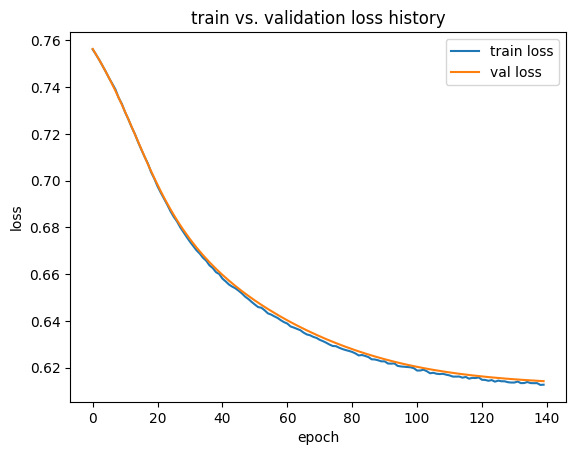

In [19]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
# reload the best model
model.load_state_dict(torch.load(saved_path))
model.to(device)

MultiLabelBiLSTM(
  (embedding): Embedding(24000, 128)
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=33, bias=True)
)

In [22]:
def test_model(test_dl, model, loss_fn, threshold=0.5):
    test_loss = 0.0
    all_logits = []
    all_probs = []
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for X_batch, y_batch, lengths in test_dl:
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            
            # Forward pass: get predicted probabilities
            logits = model(X_batch, lengths)  # Shape: (batch_size, num_classes)
            
            # Calculate loss for this batch
            loss = loss_fn(logits, y_batch)
            test_loss += loss.item()
            
            # Get predicted probabilities (our model already applies sigmoid)
            probs = logits  
            
            # Convert probabilities to binary predictions using threshold
            preds = (probs >= threshold).float()
            
            # Collect outputs and ground truth for evaluation
            all_logits.append(logits.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_true.append(y_batch.cpu().numpy())
    
    # Average test loss over batches
    test_loss /= len(test_dl)
    
    # Concatenate outputs from all batches
    all_true = np.concatenate(all_true, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)
    
    print(f"Test Loss: {test_loss:.4f}")
    return all_logits, all_probs, all_preds, all_true

In [32]:
# Test 1
"""
import torch.nn as nn

class MultiLabelLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        # LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, num_classes)  # Output size = number of labels
        
    def forward(self, x, lengths):
        # Convert token IDs into embeddings
        x = self.embedding(x)

        # Pack padded sequences for efficient LSTM processing
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # LSTM forward pass
        out, (h, c) = self.lstm(packed_x)
        
        # Fully connected layer with sigmoid activation (multi-label)
        return torch.sigmoid(self.fc(h[-1]))  # Sigmoid for independent label probabilities

        Batch size: 64
        (val_epoch_loss + 0.00009) < min_val_loss
        Time consumed: 9.58 minutes
        Epochs needed: N/A (forgot to note)
"""
# Evaluate the model on the test set using the test_model function
all_logits, all_probs, all_preds, all_true = test_model(test_dl, model, loss_fn, threshold=0.5)

# Create a list of output class names from the dataframe (excluding 'text_raw')
output_classes = list(df_loreal.columns[1:34])  # Adjust if needed

# Print classification metrics for each label
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=output_classes))

Test Loss: 0.6121
Classification Report:
                     precision    recall  f1-score   support

  dark_pigmentation       0.00      0.00      0.00       261
               acne       0.00      0.00      0.00       225
        eye_contour       0.00      0.00      0.00       149
        homogeneity       0.00      0.00      0.00      1063
      lack_firmness       0.00      0.00      0.00       292
      lack_radiance       0.61      0.93      0.74      1150
              pores       0.00      0.00      0.00       311
         fine_lines       0.00      0.00      0.00         5
wrinkles_fine-lines       0.00      0.00      0.00       657
       eye-wrinkles       0.00      0.00      0.00       108
      undereye-bags       0.00      0.00      0.00       107
            generic       0.00      0.00      0.00        27
              18-34       0.91      1.00      0.96      1711
              35-54       0.94      1.00      0.97      1765
              55-99       0.95      1.00   

In [65]:
# Test 2
"""
import torch.nn as nn

class MultiLabelLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        # LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, num_classes)  # Output size = number of labels
        
    def forward(self, x, lengths):
        # Convert token IDs into embeddings
        x = self.embedding(x)

        # Pack padded sequences for efficient LSTM processing
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # LSTM forward pass
        out, (h, c) = self.lstm(packed_x)
        
        # Fully connected layer with sigmoid activation (multi-label)
        return torch.sigmoid(self.fc(h[-1]))  # Sigmoid for independent label probabilities

        Batch size: 128
        (val_epoch_loss + 0.000009) < min_val_loss
        Time consumed: 15min
        Epochs needed:
"""
# Evaluate the model on the test set using the test_model function
all_logits, all_probs, all_preds, all_true = test_model(test_dl, model, loss_fn, threshold=0.5)

# Create a list of output class names from the dataframe (excluding 'text_raw')
output_classes = list(df_loreal.columns[1:34])  # Adjust if needed

# Print classification metrics for each label
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=output_classes))

Test Loss: 0.6130
Classification Report:
                     precision    recall  f1-score   support

  dark_pigmentation       0.00      0.00      0.00       261
               acne       0.00      0.00      0.00       225
        eye_contour       0.00      0.00      0.00       149
        homogeneity       0.78      0.01      0.01      1063
      lack_firmness       0.00      0.00      0.00       292
      lack_radiance       0.62      0.99      0.76      1150
              pores       0.00      0.00      0.00       311
         fine_lines       0.00      0.00      0.00         5
wrinkles_fine-lines       0.00      0.00      0.00       657
       eye-wrinkles       0.00      0.00      0.00       108
      undereye-bags       0.00      0.00      0.00       107
            generic       0.00      0.00      0.00        27
              18-34       0.91      1.00      0.96      1711
              35-54       0.94      1.00      0.97      1765
              55-99       0.95      1.00   

In [69]:
# Test 3
"""
import torch.nn as nn

class MultiLabelGRU(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(MultiLabelGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x, lengths):
        x = self.embedding(x)
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        # GRU returns output and hidden state (no cell state)
        packed_out, h = self.gru(packed_x)
        # Use the last hidden state for classification
        return torch.sigmoid(self.fc(h[-1]))

        Batch size: 128
        (val_epoch_loss + 0.00009) < min_val_loss
        Time consumed: 
        Epochs needed:
"""
# Evaluate the model on the test set using the test_model function
all_logits, all_probs, all_preds, all_true = test_model(test_dl, model, loss_fn, threshold=0.5)

# Create a list of output class names from the dataframe (excluding 'text_raw')
output_classes = list(df_loreal.columns[1:34])  # Adjust if needed

# Print classification metrics for each label
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=output_classes))

Test Loss: 0.6130
Classification Report:
                     precision    recall  f1-score   support

  dark_pigmentation       0.00      0.00      0.00       261
               acne       0.00      0.00      0.00       225
        eye_contour       0.00      0.00      0.00       149
        homogeneity       0.78      0.01      0.01      1063
      lack_firmness       0.00      0.00      0.00       292
      lack_radiance       0.62      0.99      0.76      1150
              pores       0.00      0.00      0.00       311
         fine_lines       0.00      0.00      0.00         5
wrinkles_fine-lines       0.00      0.00      0.00       657
       eye-wrinkles       0.00      0.00      0.00       108
      undereye-bags       0.00      0.00      0.00       107
            generic       0.00      0.00      0.00        27
              18-34       0.91      1.00      0.96      1711
              35-54       0.94      1.00      0.97      1765
              55-99       0.95      1.00   

In [23]:
# Test 4
"""
import torch.nn as nn

class MultiLabelBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(MultiLabelBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Bidirectional LSTM: hidden size is doubled after concatenation
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
    def forward(self, x, lengths):
        x = self.embedding(x)
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h, c) = self.lstm(packed_x)
        # For a single layer bidirectional LSTM, h[-2] is from the forward and h[-1] from the backward pass.
        h_forward = h[-2]
        h_backward = h[-1]
        h_combined = torch.cat((h_forward, h_backward), dim=1)
        return torch.sigmoid(self.fc(h_combined))

        Batch size: 128
        (val_epoch_loss + 0.00009) < min_val_loss
        Time consumed: 
        Epochs needed:
"""
# Evaluate the model on the test set using the test_model function
all_logits, all_probs, all_preds, all_true = test_model(test_dl, model, loss_fn, threshold=0.5)

# Create a list of output class names from the dataframe (excluding 'text_raw')
output_classes = list(df_loreal.columns[1:34])  # Adjust if needed

# Print classification metrics for each label
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=output_classes))

Test Loss: 0.6136
Classification Report:
                     precision    recall  f1-score   support

  dark_pigmentation       0.00      0.00      0.00       255
               acne       0.00      0.00      0.00       231
        eye_contour       0.00      0.00      0.00       157
        homogeneity       0.00      0.00      0.00      1095
      lack_firmness       0.00      0.00      0.00       306
      lack_radiance       0.63      0.88      0.74      1199
              pores       0.00      0.00      0.00       316
         fine_lines       0.00      0.00      0.00         2
wrinkles_fine-lines       0.00      0.00      0.00       662
       eye-wrinkles       0.00      0.00      0.00       121
      undereye-bags       0.00      0.00      0.00       114
            generic       0.00      0.00      0.00        29
              18-34       0.90      1.00      0.95      1691
              35-54       0.94      1.00      0.97      1758
              55-99       0.95      1.00   

In [ ]:
# Test 5
"""


        Batch size: 128
        (val_epoch_loss + 0.00009) < min_val_loss
        Time consumed: 
        Epochs needed:
"""
# Evaluate the model on the test set using the test_model function
all_logits, all_probs, all_preds, all_true = test_model(test_dl, model, loss_fn, threshold=0.5)

# Create a list of output class names from the dataframe (excluding 'text_raw')
output_classes = list(df_loreal.columns[1:34])  # Adjust if needed

# Print classification metrics for each label
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=output_classes))